In [1]:
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import seaborn as sns
# set darkgrid style
sns.set_style('darkgrid')

In [2]:
# load 
df = pd.read_feather('btc2021_05_21.ftr')
df.reset_index(drop=True, inplace=True)
df['quantity_cumsum'] = df['quantity'].cumsum()
df['date'] = pd.to_datetime(df['event_time']*1e6)
df['log_return'] = np.log(df['price']).diff()
# filter to maker true
# df = df[df['is_maker'] == True]

In [3]:
df.columns
# ['event_time', 'trade_id', 'price', 'quantity', 'buyer_order_id',
#        'seller_order_id', 'trade_execution_time', 'is_maker', 'exchange_name',
#        'symbol_name', 'message_type']

Index(['event_time', 'trade_id', 'price', 'quantity', 'buyer_order_id',
       'seller_order_id', 'trade_execution_time', 'is_maker', 'exchange_name',
       'symbol_name', 'message_type', 'quantity_cumsum', 'date', 'log_return'],
      dtype='object')

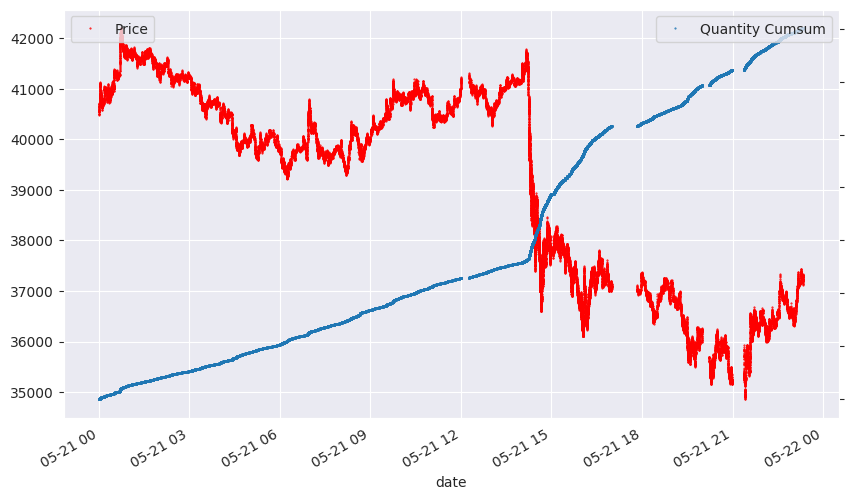

In [4]:
# Plot the price on the primary axis
ax1 = df[::100].plot(x='date', y='price', figsize=(10, 6), marker='.', lw=0, ms=1, color='r', label='Price')
# Create a twin axis for the quantity_cumsum plot
ax2 = ax1.twinx()
df[::100].plot(x='date', y='quantity_cumsum', marker='.', lw=0, ms=1, ax=ax2, label='Quantity Cumsum')
# Remove the y-axis tick labels for quantity_cumsum
ax2.set_yticklabels([])
# Remove the grid for the quantity plot
ax2.grid(False)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')




In [5]:

# Initial setup: Calculating time deltas to identify gaps
df['time_delta'] = df['event_time'] - df['event_time'].shift(1)
df['since'] = df['event_time'] - df['event_time'].shift(1)
df['until'] = df['event_time'].shift(-1) - df['event_time']
df_before_resample = df.copy()

# Resampling to a regular 100ms time grid
start_time = df['event_time'].values[0] - (df['event_time'].values[0] % 100)
end_time = df['event_time'].values[-1] - (df['event_time'].values[-1] % 100)
rows_needed = int((end_time - start_time) / 100)
time_range = np.arange(start_time, end_time, 100)

df_reg = pd.DataFrame(time_range, columns=['event_time'])
df_reg['resample'] = 1
df['resample'] = 0

df_combined = pd.concat([df, df_reg], ignore_index=True).sort_values('event_time')
df_combined['since'] = df_combined['since'].bfill()
df_combined['until'] = df_combined['until'].ffill()
df_combined['price'] = df_combined['price'].ffill()

dft = df_combined[df_combined['resample'] == 1].copy()
dft.reset_index(drop=True, inplace=True)
dft = dft[['event_time', 'price', 'since', 'until']]
dft['log_return'] = np.log(dft['price']) - np.log(dft['price'].shift(1))

# Resampling based on volume
df = df_before_resample.copy()
start_vol = 0
end_vol = df['quantity'].sum()
vol_interval = end_vol / rows_needed

vol_range = np.arange(start_vol, end_vol, vol_interval)
df_vol_reg = pd.DataFrame(vol_range, columns=['quantity_cumsum'])
df_vol_reg['resample'] = 1
df['resample'] = 0

df_combined = pd.concat([df, df_vol_reg], ignore_index=True).sort_values('quantity_cumsum')
df_combined['since'] = df_combined['since'].bfill()
df_combined['until'] = df_combined['until'].ffill()
df_combined['price'] = df_combined['price'].ffill()

dfv = df_combined[df_combined['resample'] == 1].copy()
dfv.reset_index(drop=True, inplace=True)
dfv = dfv[['event_time', 'price', 'since', 'until']]
dfv['log_return'] = np.log(dfv['price']) - np.log(dfv['price'].shift(1))

# Identifying and expanding the identification of disconnects
dft['disconnect'] = (dft['since'] > 1000) | (dft['until'] > 1000)
dft['disconnect2'] = (dft['disconnect'].shift(1) | dft['disconnect'] | dft['disconnect'].shift(-1)).astype(int)

dfv['disconnect'] = (dfv['since'] > 1000) | (dfv['until'] > 1000)
dfv['disconnect2'] = (dfv['disconnect'].shift(1) | dfv['disconnect'] | dfv['disconnect'].shift(-1)).astype(int)

# Filtering out disconnects
dftf = dft[dft['disconnect2'] == 0].copy()
dfvt = dfv[dfv['disconnect2'] == 0].copy()

# Output some key information
print("Max and Min Log Returns for Time-based Resampling:")
print(dft['log_return'].max(), dft['log_return'].min())

print("Max and Min Log Returns for Volume-based Resampling:")
print(dfv['log_return'].max(), dfv['log_return'].min())

print("Number of Disconnects Identified (Time-based):", dft['disconnect2'].sum())
print("Number of Disconnects Identified (Volume-based):", dfv['disconnect2'].sum())


Max and Min Log Returns for Time-based Resampling:
0.013963652035346996 -0.012677165082173758
Max and Min Log Returns for Volume-based Resampling:
0.019875851582899173 -0.012372644192684135
Number of Disconnects Identified (Time-based): 66638
Number of Disconnects Identified (Volume-based): 51


In [6]:
# print skewness and kurtosis
print("Skewness of Time-based Resampling:", dft['log_return'].skew())
print("Kurtosis of Time-based Resampling:", dft['log_return'].kurtosis())

print("Skewness of Volume-based Resampling:", dfv['log_return'].skew())
print("Kurtosis of Volume-based Resampling:", dfv['log_return'].kurtosis())

Skewness of Time-based Resampling: -0.10786717721030617
Kurtosis of Time-based Resampling: 276.1160114479435
Skewness of Volume-based Resampling: 0.46292376886320424
Kurtosis of Volume-based Resampling: 175.41432658876667


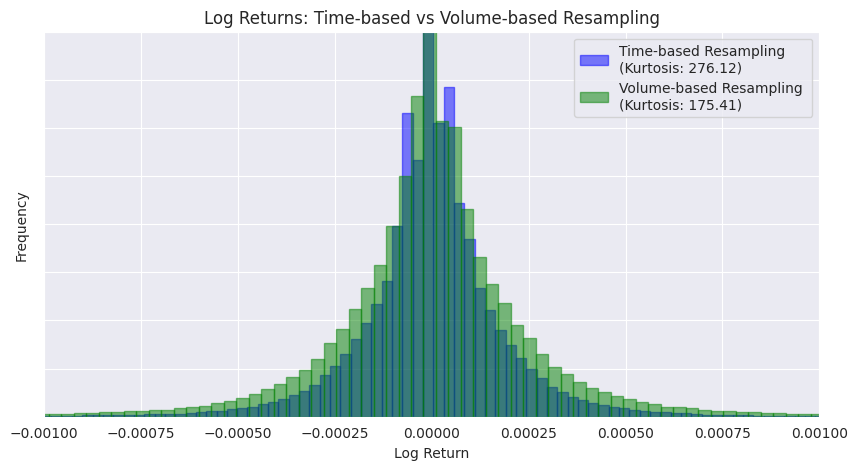

In [7]:
# Calculate kurtosis for both resampling methods
kurtosis_time_based = dft['log_return'].kurtosis()
kurtosis_volume_based = dfv['log_return'].kurtosis()

# Plotting histograms of log returns for both resampling methods on the same axis
plt.figure(figsize=(10, 5))

# Plotting time-based resampling histogram
dft['log_return'].hist(bins=1000, color='blue', edgecolor='blue', alpha=0.5, label=f'Time-based Resampling \n(Kurtosis: {kurtosis_time_based:.2f})')

# Plotting volume-based resampling histogram
dfv['log_return'].hist(bins=1000, color='green', edgecolor='green', alpha=0.5, label=f'Volume-based Resampling \n(Kurtosis: {kurtosis_volume_based:.2f})')

plt.title('Log Returns: Time-based vs Volume-based Resampling')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.ylim(0, 40000)
plt.xlim(-0.001, 0.001)

# Removing the y-axis tick labels
plt.gca().set_yticklabels([])

plt.legend()
plt.show()


Both the time-based and volume-based resampling methods of financial data exhibit high kurtosis values, indicating distributions with heavy tails and a higher likelihood of extreme price movements. Both methods are far from the normal distribution's kurtosis of 3. This tail-heaviness underscores a significant tail risk in the data.  
  
The volume-based resampling shows a lower kurtosis compared to the time-based method, suggesting it is the better option for analysis seeking to minimize the impact of extreme outliers. 